# Standardised signal structure:
$
[S]   
$
$
[C]   
$
$
\mathbf{|||}
$
$
[C]
$
$
[CP_{KS}]
$
$
[KS \times 4]
$
$
[\text{DATA}]
$
$
[CP_{KS}]
$
$
[KS \times 4]
$
$
[C]
$
$
\mathbf{|||}
$
$
... \text{repeat}...
$
$
\mathbf{|||}
$
$
[C]  
$
$
[S]   
$

Goal is to be able to extract the $[\text{DATA}]$ section 

Each $[\text{DATA}]$ frame is comprised of 128 OFDM symbols

Key:
- $C$: Chirp
- $KS$: Known Symbol
- $CP_i$: Cyclic Prefix for symbol $i$


In [1]:
import numpy as np
from scipy import signal
import scipy
import matplotlib.pyplot as plt
from numpy import genfromtxt
plt.rcParams["figure.figsize"] = (20,3)

In [2]:
# Silence before transmission begins, to accomodate some computers making
# weird noises at the start of playback of files, in seconds
PRE_TRANSMISSION_SILENCE = 1

# Length of chirp in seconds, and frequencies for it to go between in Hz
CHIRP_LENGTH = 1
CHIRP_START_FREQ = 1_000
CHIRP_STOP_FREQ = 10_000

# Sampling frequency for audio, in Hz
SAMPLING_FREQ = 48_000

# FFT length
FFT_LEN = 4096

# Cyclic prefix length
PREFIX_LEN = 512

# Send known symbol every 5th symbol
KNOWN_SYMBOLS = 4

# Data start and stop frequency, and therefore index within OFDM
DATA_START_FREQ = 1_000
DATA_STOP_FREQ = 10_000
DATA_START_INDEX = 86
DATA_STOP_INDEX = 853 + 1   # +1 because standard is [] but we are [)

# Frame length
FRAME_LENGTH = 128

In [3]:
def getChirp(self=None):
    # TODO: Try windowing the chirps (cosine rolloff suggested) to prevent ringing
    t = np.linspace(0, CHIRP_LENGTH, CHIRP_LENGTH*SAMPLING_FREQ)
    w = signal.chirp(t, f0=CHIRP_START_FREQ, f1=CHIRP_STOP_FREQ, t1=CHIRP_LENGTH, method='linear')
    # window = signal.windows.cosine(CHIRP_LENGTH*SAMPLING_FREQ)
    # return w*window
    return w

In [4]:
def getSyncPrefix():
    w = getChirp()
    z = np.zeros(PRE_TRANSMISSION_SILENCE*SAMPLING_FREQ)
    w = np.concatenate((z, w))
    return w

In [5]:
  def getSyncSuffix():
        w = getChirp()
        z = np.zeros(PRE_TRANSMISSION_SILENCE*SAMPLING_FREQ)
        w = np.concatenate((w, z))
        return w   

In [6]:
def getKnownSymbol():
    packet_len = FFT_LEN//2 - 1
    known_symbol = np.load("known_ofdm_symbol.npy")
    assert len(known_symbol) == packet_len*2 + 2
    return known_symbol

print(getKnownSymbol())
print(len(getKnownSymbol()))

[ 0.        +0.j         -0.70710678-0.70710678j -0.70710678-0.70710678j
 ... -0.70710678+0.70710678j -0.70710678+0.70710678j
 -0.70710678+0.70710678j]
4096


In [7]:
def getKnownSymbolSeq():
    known_symbol_cp = getKnownSymbol()[-PREFIX_LEN:]
    known_symbol_repeats = np.repeat(getKnownSymbol(),4)
    return np.concatenate((known_symbol_cp, known_symbol_repeats))

In [8]:
def gray(data):
    
    a = iter(data)
    l = list(zip(a, a))
    d = np.zeros(len(data) //2 , dtype=np.complex_)
    for i,j in enumerate(l):
        
        if j == (0,0):
            d[i] = 1+1j
        elif j == (0,1):
            d[i] = -1+1j
        elif j == (1,1):
            d[i] = -1-1j  
        elif j == (1,0):
            d[i] = 1-1j
            
    return d / np.sqrt(2)

In [9]:
# f = open("Schmidl_and_Cox_data.txt", "r")
# data_test = list(f.read())
# print(f"Length of data: {len(data_test)}")

In [10]:
data_test = np.random.choice([0,1], size = 4094*256)
print(len(data_test))
print(data_test)

1048064
[0 1 1 ... 0 0 0]


In [11]:
p = gray(data_test)

print(len(p))
print(p[0:100])

524032
[-0.70710678+0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j -0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j -0.70710678-0.70710678j
  0.70710678+0.70710678j  0.70710678+0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j -0.70710678-0.70710678j
 -0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678-0.70710678j
 -0.70710678+0.70710678j -0.70710678+0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678-0.70710678j
 -0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678+0.70710678j
 -0.70710678-0.70710678j -0.70710678-0.70710

In [12]:
def modOFDM(symbols):
    
    packet_len = FFT_LEN // 2 - 1
    print(packet_len)
    print(len(symbols))
    print(len(symbols)%packet_len)
    print(packet_len - len(symbols)%packet_len)
    
    symbols = np.append(symbols,np.zeros(packet_len - len(symbols)%packet_len,dtype=complex))
    
    ofdm_stream = []
    
    output = getSyncPrefix()

    for i in range(len(symbols) // packet_len):
        
        packet_symbol = symbols[packet_len*i:packet_len*(i+1)]
        data_block = np.concatenate((np.zeros(1), packet_symbol, np.zeros(1), np.flip(np.conjugate(packet_symbol))))
        ofdm_block = np.fft.ifft(data_block, n = FFT_LEN)
        ofdm_stream.append(np.append(ofdm_block[-PREFIX_LEN:],ofdm_block))

    return ofdm_stream

OFDM_sequence = modOFDM(p)

2047
524032
0
2047


In [13]:
flat_OFDM1 = [item for sublist in OFDM_sequence[0:128] for item in sublist]
flat_OFDM2 = [item for sublist in OFDM_sequence[128:256] for item in sublist]
print(len(flat_OFDM1))
print(len(flat_OFDM2))

589824
589824


In [14]:
block1 = np.concatenate((getChirp(),getKnownSymbolSeq(),flat_OFDM1,getKnownSymbolSeq(),getChirp()))
block2 = np.concatenate((getChirp(),getKnownSymbolSeq(),flat_OFDM2,getKnownSymbolSeq(),getChirp()))

OFDM_signal = np.concatenate((getSyncPrefix(),block1,block2,getSyncSuffix()))
print(len(OFDM_signal))



1631232


In [15]:
def channel_sim(Tx_signal, h, noise): # inputs are the signal emitted by the transmitter, and channel impulse response
    filtered = scipy.signal.lfilter(h, (1,), Tx_signal)
    noisy = np.random.normal(loc=0, scale = 0.05, size = len(Tx_signal))
    if noise == True:
        return noisy + filtered
    else: 
        return filtered
    
    
channel = genfromtxt('channel.csv', delimiter=',') # simulated channel from week 1 challenge

# channel = [1]

OFDM_signal = channel_sim(OFDM_signal, channel, noise = True)

In [16]:
expected_length = (FFT_LEN+PREFIX_LEN)*FRAME_LENGTH + (FFT_LEN*KNOWN_SYMBOLS+PREFIX_LEN)*2 + (SAMPLING_FREQ*CHIRP_LENGTH)*2
print(expected_length)

719616


In [17]:
def convolve(x):
    return np.convolve(x, getChirp()[::-1])

In [18]:
def countData(intput_audio):
    return (len(intput_audio) // expected_length)*2+2

In [19]:
def findStart():
    a = convolve(OFDM_signal)
    plt.plot(a)
    l = []
    for i in range(countData(OFDM_signal)):
        plt.axvline(np.argmax(a),color = 'red', linestyle = 'dashed')
        l.append(np.argmax(a))
        a[np.argmax(a)-1000:np.argmax(a)+1000] = [0]*2000
        
        
    plt.show()
    
    
    l.sort
        
    return np.sort(l), a

/Users/jamesroy/miniconda3/envs/SF3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


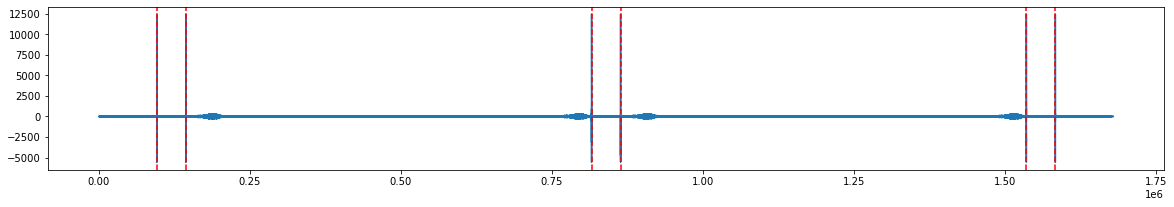

In [20]:
l,a = findStart()

[-0.04531795+0.j  0.0295533 +0.j  0.07593128+0.j ...  0.11862216+0.j
  0.06623625+0.j  0.02315781+0.j]
[  95999  143999  815615  863615 1535231 1583231]
[ 48000 671616  48000 671616  48000]


/Users/jamesroy/miniconda3/envs/SF3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


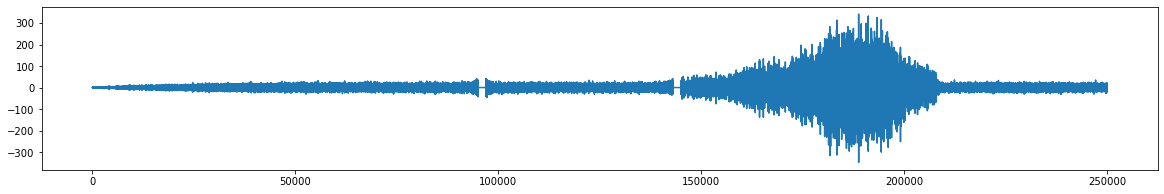

In [23]:
print(a)
print(l)
print(np.diff(l))
plt.plot(a[0:250000])